In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv('./data/tacred_stats.tsv', header=0, delimiter='\t')
df = df[:-1]
relations = df["# Relation"].to_list()
relation_to_id = {r: i for i, r in enumerate(relations)}

In [5]:
relation_to_frequency = {r:0 for r in relation_to_id.keys()}

lengths = []
test_data = json.load(open('data/controlled_tacred_test_sub1_subj.json'))
for sample in test_data:
    relation_labels = sample['correct_relation']
    tokens = sample['tokens']
    lengths.append(len(tokens))


In [6]:
print('max:', max(lengths))
print('min:', min(lengths))
print('mean:', np.mean(lengths))


max: 101
min: 3
mean: 38.72482535355257


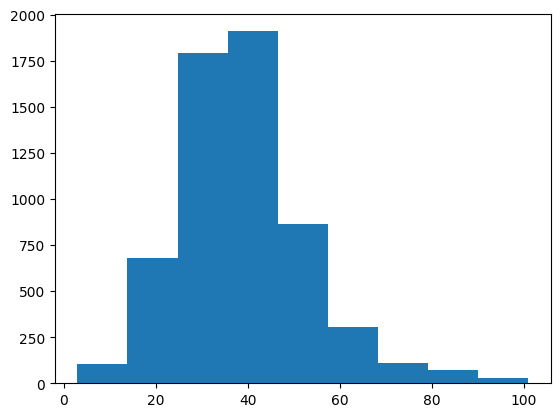

In [7]:
num_bins = 10
_, bins, _ = plt.hist(lengths, bins=num_bins-1)

In [8]:
bins

array([  3.        ,  13.88888889,  24.77777778,  35.66666667,
        46.55555556,  57.44444444,  68.33333333,  79.22222222,
        90.11111111, 101.        ])

In [9]:
def get_bin(bins, value):
    for i, b in enumerate(bins):
        if value <= b:
            return i
    return len(bins) - 1

In [10]:
relation_to_id

{'no_relation': 0,
 'org:alternate_names': 1,
 'org:city_of_headquarters': 2,
 'org:country_of_headquarters': 3,
 'org:dissolved': 4,
 'org:founded': 5,
 'org:founded_by': 6,
 'org:member_of': 7,
 'org:members': 8,
 'org:number_of_employees/members': 9,
 'org:parents': 10,
 'org:political/religious_affiliation': 11,
 'org:shareholders': 12,
 'org:stateorprovince_of_headquarters': 13,
 'org:subsidiaries': 14,
 'org:top_members/employees': 15,
 'org:website': 16,
 'per:age': 17,
 'per:alternate_names': 18,
 'per:cause_of_death': 19,
 'per:charges': 20,
 'per:children': 21,
 'per:cities_of_residence': 22,
 'per:city_of_birth': 23,
 'per:city_of_death': 24,
 'per:countries_of_residence': 25,
 'per:country_of_birth': 26,
 'per:country_of_death': 27,
 'per:date_of_birth': 28,
 'per:date_of_death': 29,
 'per:employee_of': 30,
 'per:origin': 31,
 'per:other_family': 32,
 'per:parents': 33,
 'per:religion': 34,
 'per:schools_attended': 35,
 'per:siblings': 36,
 'per:spouse': 37,
 'per:stateorpr

In [11]:
import sys
from collections import Counter

NO_RELATION = relation_to_id['no_relation']


def score(key, prediction):
    correct_by_relation = Counter()
    guessed_by_relation = Counter()
    gold_by_relation    = Counter()

    # Loop over the data to compute a score
    for row in range(len(key)):
        gold = key[row]
        guess = prediction[row]

        if gold == NO_RELATION and guess == NO_RELATION:
            pass
        elif gold == NO_RELATION and guess != NO_RELATION:
            guessed_by_relation[guess] += 1
        elif gold != NO_RELATION and guess == NO_RELATION:
            gold_by_relation[gold] += 1
        elif gold != NO_RELATION and guess != NO_RELATION:
            guessed_by_relation[guess] += 1
            gold_by_relation[gold] += 1
            if gold == guess:
                correct_by_relation[guess] += 1

    prec_micro = 1.0
    if sum(guessed_by_relation.values()) > 0:
        prec_micro   = float(sum(correct_by_relation.values())) / float(sum(guessed_by_relation.values()))
    recall_micro = 0.0
    if sum(gold_by_relation.values()) > 0:
        recall_micro = float(sum(correct_by_relation.values())) / float(sum(gold_by_relation.values()))
    f1_micro = 0.0
    if prec_micro + recall_micro > 0.0:
        f1_micro = 2.0 * prec_micro * recall_micro / (prec_micro + recall_micro)
    #print( "Precision (micro): {:.3%}".format(prec_micro) )
    #print( "   Recall (micro): {:.3%}".format(recall_micro) )
    #print( "       F1 (micro): {:.3%}".format(f1_micro) )
    return prec_micro, recall_micro, f1_micro

In [12]:
def get_bin_f1(model_name):

    prediction_by_length = {i:{'correct_relation': [], 'results':[]} for i in range(num_bins)}

    test_data = json.load(open('data/controlled_tacred_test_sub1_obj.json'))
    for sample in test_data:
        relation_labels = sample['correct_relation']
        result_label = sample['results'][model_name]
        tokens = sample['tokens']

        prediction_by_length[get_bin(bins, len(tokens))]['correct_relation'].append(relation_to_id[relation_labels])
        prediction_by_length[get_bin(bins, len(tokens))]['results'].append(relation_to_id[result_label])

    scores = []
    for i in range(num_bins):
        prec_micro, recall_micro, f1_micro = score(prediction_by_length[i]['results'], prediction_by_length[i]['correct_relation'])
        scores.append(f1_micro)

    return scores

In [13]:
print(get_bin_f1('LUKE'))
print(get_bin_f1('SpanBERT'))
print(get_bin_f1('SURE'))
print(get_bin_f1('UniST'))

[0.0, 0.6666666666666667, 0.7403598971722366, 0.6954022988505746, 0.689908256880734, 0.6755555555555555, 0.606060606060606, 0.631578947368421, 0.3333333333333333, 1.0]
[0.0, 0.12903225806451613, 0.31932773109243695, 0.34591194968553457, 0.3486238532110092, 0.3858823529411765, 0.3853211009174311, 0.6956521739130435, 0.0, 0.4]
[0.0, 0.22727272727272727, 0.37010676156583633, 0.35939643347050754, 0.35555555555555557, 0.3106796116504854, 0.35443037974683544, 0.15384615384615385, 0.0, 0.5]
[0.0, 0.53125, 0.6838046272493573, 0.6884615384615383, 0.6364494806421152, 0.6503340757238307, 0.6274509803921569, 0.631578947368421, 0.28571428571428575, 0.8]
